In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.vq import kmeans2, whiten

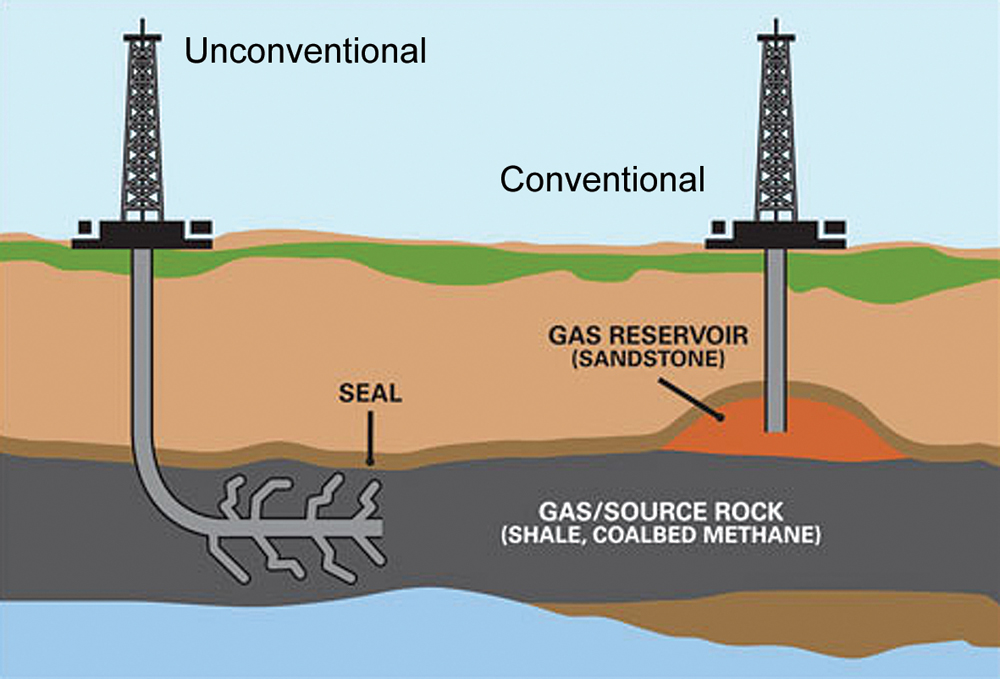

Conventional oil and gas are hydrocarbons that have been accumulated in reservoirs with good oil-water or gas-water contact. These resources are relatively easy to obtain by utilizing the natural pressure from the well and pumping operations.
Conventional sources of oil and gas are normally vertical and deviated wells with high-permeability source rocks.
To obtain hydrocarbons from conventional reservoirs, conventional drilling methods (vertical or directional drilling) and multi-zone perforations are carried out.

Unconventional oil and gas are hydrocarbons trapped in low-permeability source rock with minimal oil-water or gas-water contact. As a result, they cannot be obtained using simple drilling and perforation operations.
To obtain hydrocarbons from these hard-to-reach sources, a combination of horizontal drilling and hydraulic fracturing is done.

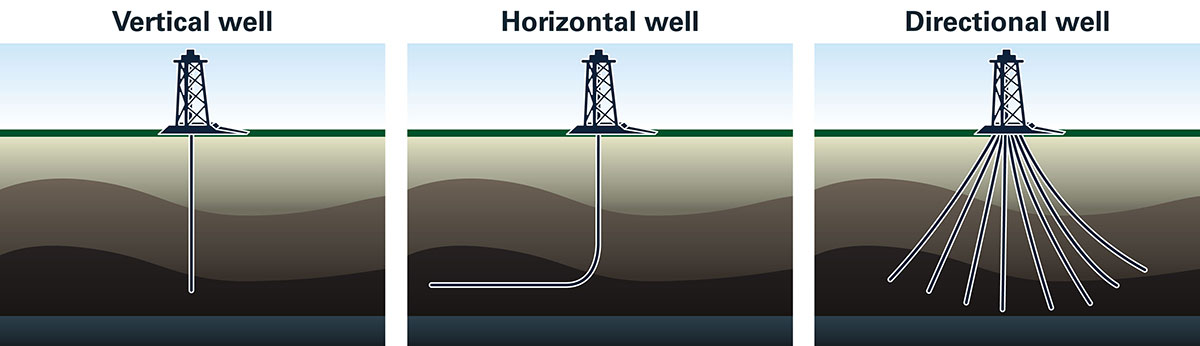

In [47]:
data = pd.read_csv('Argentina Well Data Science Challenge_M.csv', encoding='latin-1')
len(data)

1998

In [48]:
data.head()

,Well ID,Well type code,well_number,Field_Name,Operator,latitude,longitude,Measured_Depth,Drilling_Start,Drilling_end,Completion_Date,Reservoir,play_name,state_name,well_cost
0,8.799000e+13,UN,x-1001,Calmuco (CAL),Provincia Mendoza,-36.530880,-69.765530,4097.0,NaN,NaN,NaN,Unassigned,Unassigned,Mendoza,4.435899e+05
1,8.799000e+13,UN,x-1003,Calmuco (CAL),Provincia Mendoza,-36.536380,-69.768330,2618.0,NaN,NaN,NaN,Unassigned,Unassigned,Mendoza,2.592238e+05
2,8.799000e+13,UN,CHOx-1,Chanares Herrados (CHA),Chanares Herrados,-33.365903,-69.016933,15675.0,NaN,NaN,NaN,Unassigned,Unassigned,Mendoza,2.178866e+06
3,8.799000e+13,UN,CDJx-2,Cerro Dona Juana (CDJ),Geopark Argentina,-35.820042,-69.781180,11118.0,NaN,NaN,NaN,Agrio,Unassigned,Mendoza,1.269930e+06
4,8.799000e+13,UN,CHEx-1,Chanares Herrados (CHA),Chanares Herrados,-33.359458,-68.947347,12007.0,NaN,NaN,NaN,Unassigned,Unassigned,Mendoza,1.651346e+06


# EDA

In [49]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

In [50]:
missing_values_table(data)

Dataframe has 15 columns.
There are 4 columns that have missing values.


,Missing Values,% of Total Values
Completion_Date,1162,58.2
Drilling_Start,1113,55.7
Drilling_end,1113,55.7
Measured_Depth,461,23.1


1. Transfrom dates columns in appropriate format for calculations
2. Create new columns based on calculations:
    - drilling time (Drilling_end - Drilling_Start)
    - completion time (Completion_Date - Drilling_end)
    - drilling performance: Well cost per meter and Well cost per day
3. Fill missing values for Completion time and Measured Depth with mean based on well types

In [56]:
#datetime format
data['Drilling_Start'] = pd.to_datetime(data['Drilling_Start'])
data['Drilling_end'] = pd.to_datetime(data['Drilling_end'])
data['Completion_Date'] = pd.to_datetime(data['Completion_Date'])
#new column for completion time
data['Drilling_Time'] = (data['Drilling_end'] - data['Drilling_Start']).dt.days
data['Completion_Time'] = (data['Completion_Date'] - data['Drilling_end']).dt.days
#replace NA values for Drilling time on well types with the mean for those groups
data['Drilling_Time'] = data.groupby('Well type code')['Drilling_Time'].transform(lambda x: x.fillna(x.mean()))
#replace NA values for Depth based on well types with the mean for those groups
data['Measured_Depth'] = data.groupby('Well type code')['Measured_Depth'].transform(lambda x: x.fillna(x.mean()))
#replace NA values for Completion_Time based on well types with the mean for those groups
data['Completion_Time'] = data.groupby('Well type code')['Completion_Time'].transform(lambda x: x.fillna(x.mean()))

In [57]:
#new column for drilling performance
data['Cost_per_meter'] = data['well_cost']/data['Measured_Depth']
data['Cost_per_day'] = data['well_cost']/data['Completion_Time']

In [78]:
data

,Well ID,Well type code,well_number,Field_Name,Operator,latitude,longitude,Measured_Depth,Drilling_Start,Drilling_end,Completion_Date,Reservoir,play_name,state_name,well_cost,Drilling_Time,Completion_Time,Cost_per_meter,Cost_per_day
0,8.799000e+13,UN,x-1001,Calmuco (CAL),Provincia Mendoza,-36.530880,-69.765530,4097.000000,NaT,NaT,NaT,Unassigned,Unassigned,Mendoza,4.435899e+05,22.500000,29.500000,108.271876,1.503694e+04
1,8.799000e+13,UN,x-1003,Calmuco (CAL),Provincia Mendoza,-36.536380,-69.768330,2618.000000,NaT,NaT,NaT,Unassigned,Unassigned,Mendoza,2.592238e+05,22.500000,29.500000,99.015972,8.787248e+03
2,8.799000e+13,UN,CHOx-1,Chanares Herrados (CHA),Chanares Herrados,-33.365903,-69.016933,15675.000000,NaT,NaT,NaT,Unassigned,Unassigned,Mendoza,2.178866e+06,22.500000,29.500000,139.002608,7.385986e+04
3,8.799000e+13,UN,CDJx-2,Cerro Dona Juana (CDJ),Geopark Argentina,-35.820042,-69.781180,11118.000000,NaT,NaT,NaT,Agrio,Unassigned,Mendoza,1.269930e+06,22.500000,29.500000,114.222913,4.304849e+04
4,8.799000e+13,UN,CHEx-1,Chanares Herrados (CHA),Chanares Herrados,-33.359458,-68.947347,12007.000000,NaT,NaT,NaT,Unassigned,Unassigned,Mendoza,1.651346e+06,22.500000,29.500000,137.531977,5.597785e+04
5,8.799000e+13,V,CHSx-1,Puesto Pozo Cercado (PCE),Chanares Herrados,-33.404017,-69.001439,14819.000000,1986-02-07,1986-05-21,NaT,Unassigned,Unassigned,Mendoza,1.697034e+06,103.000000,36.476942,114.517465,4.652348e+04
6,8.799000e+13,UN,PPCx-1004,Puesto Pozo Cercado (PCE),Chanares Herrados,-33.359347,-68.963569,11991.000000,NaT,NaT,NaT,Barrancas,Unassigned,Mendoza,1.810493e+06,22.500000,29.500000,150.987662,6.137265e+04
7,8.799000e+13,V,S-148,El Sosneado (ESO),Petroquimica Comodoro Rivadavia,-34.991670,-69.488560,5095.000000,2001-01-15,2001-01-26,2001-03-23,Unassigned,Unassigned,Mendoza,7.331553e+05,11.000000,56.000000,143.897019,1.309206e+04
8,8.799000e+13,V,S-117,El Sosneado (ESO),Petroquimica Comodoro Rivadavia,-35.040430,-69.406200,3677.000000,1995-09-04,1995-09-16,1995-09-24,Unassigned,Unassigned,Mendoza,4.010794e+05,12.000000,8.000000,109.077890,5.013493e+04
9,8.799000e+13,V,S-131,El Sosneado (ESO),Petroquimica Comodoro Rivadavia,-35.048390,-69.407210,3740.000000,1997-01-29,1997-02-06,1997-02-13,Unassigned,Unassigned,Mendoza,3.750757e+05,8.000000,7.000000,100.287629,5.358225e+04


In [60]:
df = data.dropna(axis = 1)

,Well ID,Well type code,well_number,Field_Name,Operator,latitude,longitude,Measured_Depth,Reservoir,play_name,state_name,well_cost,Drilling_Time,Completion_Time,Cost_per_meter,Cost_per_day
0,8.799000e+13,UN,x-1001,Calmuco (CAL),Provincia Mendoza,-36.530880,-69.765530,4097.000000,Unassigned,Unassigned,Mendoza,4.435899e+05,22.500000,29.500000,108.271876,1.503694e+04
1,8.799000e+13,UN,x-1003,Calmuco (CAL),Provincia Mendoza,-36.536380,-69.768330,2618.000000,Unassigned,Unassigned,Mendoza,2.592238e+05,22.500000,29.500000,99.015972,8.787248e+03
2,8.799000e+13,UN,CHOx-1,Chanares Herrados (CHA),Chanares Herrados,-33.365903,-69.016933,15675.000000,Unassigned,Unassigned,Mendoza,2.178866e+06,22.500000,29.500000,139.002608,7.385986e+04
3,8.799000e+13,UN,CDJx-2,Cerro Dona Juana (CDJ),Geopark Argentina,-35.820042,-69.781180,11118.000000,Agrio,Unassigned,Mendoza,1.269930e+06,22.500000,29.500000,114.222913,4.304849e+04
4,8.799000e+13,UN,CHEx-1,Chanares Herrados (CHA),Chanares Herrados,-33.359458,-68.947347,12007.000000,Unassigned,Unassigned,Mendoza,1.651346e+06,22.500000,29.500000,137.531977,5.597785e+04
5,8.799000e+13,V,CHSx-1,Puesto Pozo Cercado (PCE),Chanares Herrados,-33.404017,-69.001439,14819.000000,Unassigned,Unassigned,Mendoza,1.697034e+06,103.000000,36.476942,114.517465,4.652348e+04
6,8.799000e+13,UN,PPCx-1004,Puesto Pozo Cercado (PCE),Chanares Herrados,-33.359347,-68.963569,11991.000000,Barrancas,Unassigned,Mendoza,1.810493e+06,22.500000,29.500000,150.987662,6.137265e+04
7,8.799000e+13,V,S-148,El Sosneado (ESO),Petroquimica Comodoro Rivadavia,-34.991670,-69.488560,5095.000000,Unassigned,Unassigned,Mendoza,7.331553e+05,11.000000,56.000000,143.897019,1.309206e+04
8,8.799000e+13,V,S-117,El Sosneado (ESO),Petroquimica Comodoro Rivadavia,-35.040430,-69.406200,3677.000000,Unassigned,Unassigned,Mendoza,4.010794e+05,12.000000,8.000000,109.077890,5.013493e+04
9,8.799000e+13,V,S-131,El Sosneado (ESO),Petroquimica Comodoro Rivadavia,-35.048390,-69.407210,3740.000000,Unassigned,Unassigned,Mendoza,3.750757e+05,8.000000,7.000000,100.287629,5.358225e+04


In [61]:
missing_values_table(df)

Dataframe has 16 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [79]:
m1 = data.groupby('Well type code')['Measured_Depth'].mean()
m1 = pd.DataFrame(m1)
m1

,Measured_Depth
Well type code,
H,12334.500000
UN,5625.433144
V,5662.956443


In [14]:
m2 = data.groupby('Well type code')['Completion_Time'].mean()
m2 = pd.DataFrame(m2)

,Completion_Time
Well type code,
H,53.400000
UN,29.500000
V,36.476942


In [16]:
m3 = data.groupby('Well type code')['well_cost'].mean()
m3 = pd.DataFrame(m3)

,well_cost
Well type code,
H,2.538925e+06
UN,8.741440e+05
V,7.346374e+05


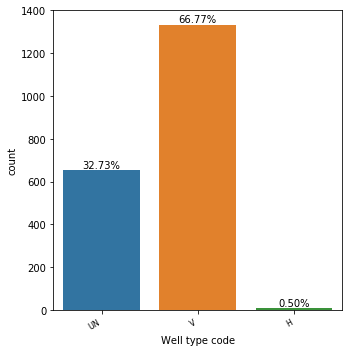

In [63]:
ncount = len(df)
plt.figure(figsize=(5,5))
ax = sns.countplot(data=df, x = 'Well type code')
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 8, rotation=30, ha="right")
plt.tight_layout()
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.2f}%'.format(100.*y/ncount), (x.mean(), y), ha='center', va='bottom')
plt.show()

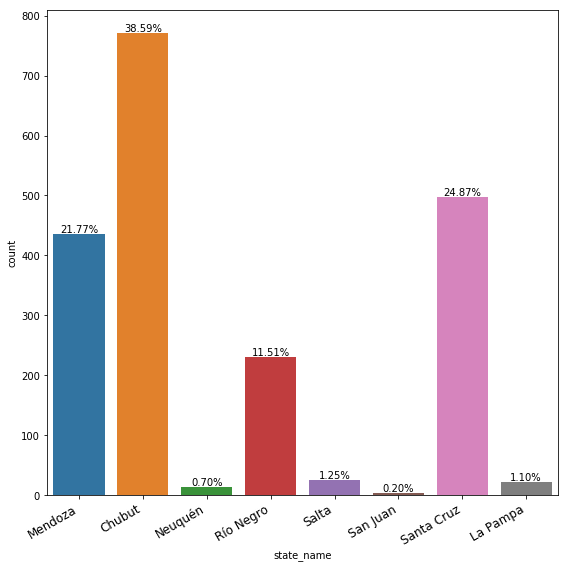

In [64]:
ncount = len(df)
plt.figure(figsize=(8,8))
ax = sns.countplot(data=df, x = 'state_name')
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 12, rotation=30, ha="right")
plt.tight_layout()
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.2f}%'.format(100.*y/ncount), (x.mean(), y),ha='center', va='bottom')
plt.show()

In [65]:
df.describe()

,Well ID,latitude,longitude,Measured_Depth,well_cost,Drilling_Time,Completion_Time,Cost_per_meter,Cost_per_day
count,1.998000e+03,1998.000000,1998.000000,1998.000000,1.998000e+03,1998.000000,1998.000000,1998.000000,1.998000e+03
mean,9.065866e+13,-42.516174,-68.317730,5684.065151,7.893322e+05,15.880488,34.277898,3232.493625,inf
std,2.847580e+12,5.342309,1.914794,4045.613999,4.393639e+05,885.079367,847.836828,21805.368809,NaN
min,8.799000e+13,-69.506300,-70.788750,3.618000,1.147218e+05,-32798.000000,-26465.000000,15.841707,-1.351470e+01
25%,8.899040e+13,-46.005871,-69.073895,4189.750000,5.369574e+05,12.416953,24.000000,111.393555,1.800814e+04
50%,8.899120e+13,-45.776925,-68.320367,5662.956443,7.275993e+05,20.000000,29.500000,133.215495,2.423014e+04
75%,9.499070e+13,-37.658590,-67.810833,6725.000000,9.356654e+05,22.500000,36.476942,161.675687,3.760595e+04
max,9.899080e+13,-22.042010,-29.971058,151111.000000,4.141856e+06,22050.000000,26591.000000,234817.384939,inf


In [76]:
data.groupby(by = 'Well type code').agg({'Well ID':'count', 'Measured_Depth':'mean', 'Completion_Time':'mean', 'Cost_per_meter':'mean', 'Cost_per_day':'mean'})

,Well ID,Measured_Depth,Completion_Time,Cost_per_meter,Cost_per_day
Well type code,,,,,
H,10,12334.500000,53.400000,204.703998,6.947254e+04
UN,654,5625.433144,29.500000,6083.966329,2.965344e+04
V,1334,5662.956443,36.476942,1857.242312,inf


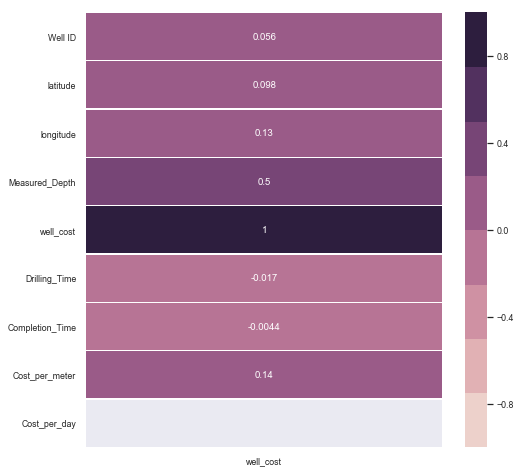

In [67]:
#list with all numerical feat
feat = ['Well ID','latitude','longitude','Measured_Depth','well_cost','Drilling_Time','Completion_Time','Cost_per_meter','Cost_per_day']
#calculate correlation between one column and all numerical feat
a = pd.DataFrame(df[feat].corrwith(df['well_cost']), columns=['well_cost'])
#display correlation matrix between features
plt.figure(figsize=(8,8)) 
sns.heatmap(a, cmap=sns.cubehelix_palette(8), annot=True, linewidths=.5, vmin=-1, vmax=1)
sns.set(font_scale=1)

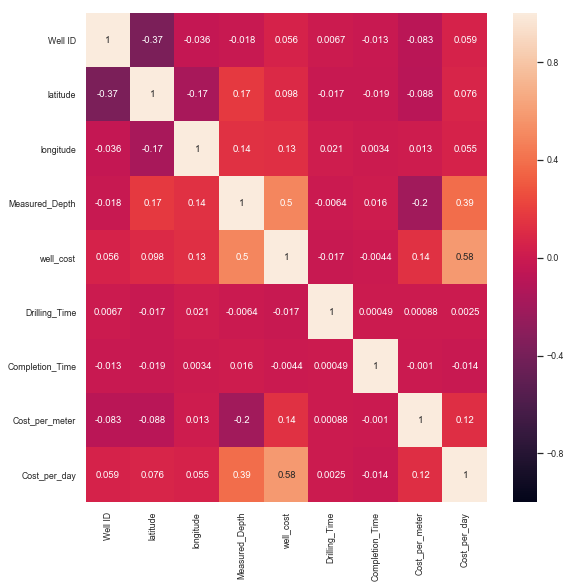

In [66]:
plt.figure(figsize=(9, 9))
sns.set(font_scale=0.8)
ax = sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1)

We see the strongest correlation has:

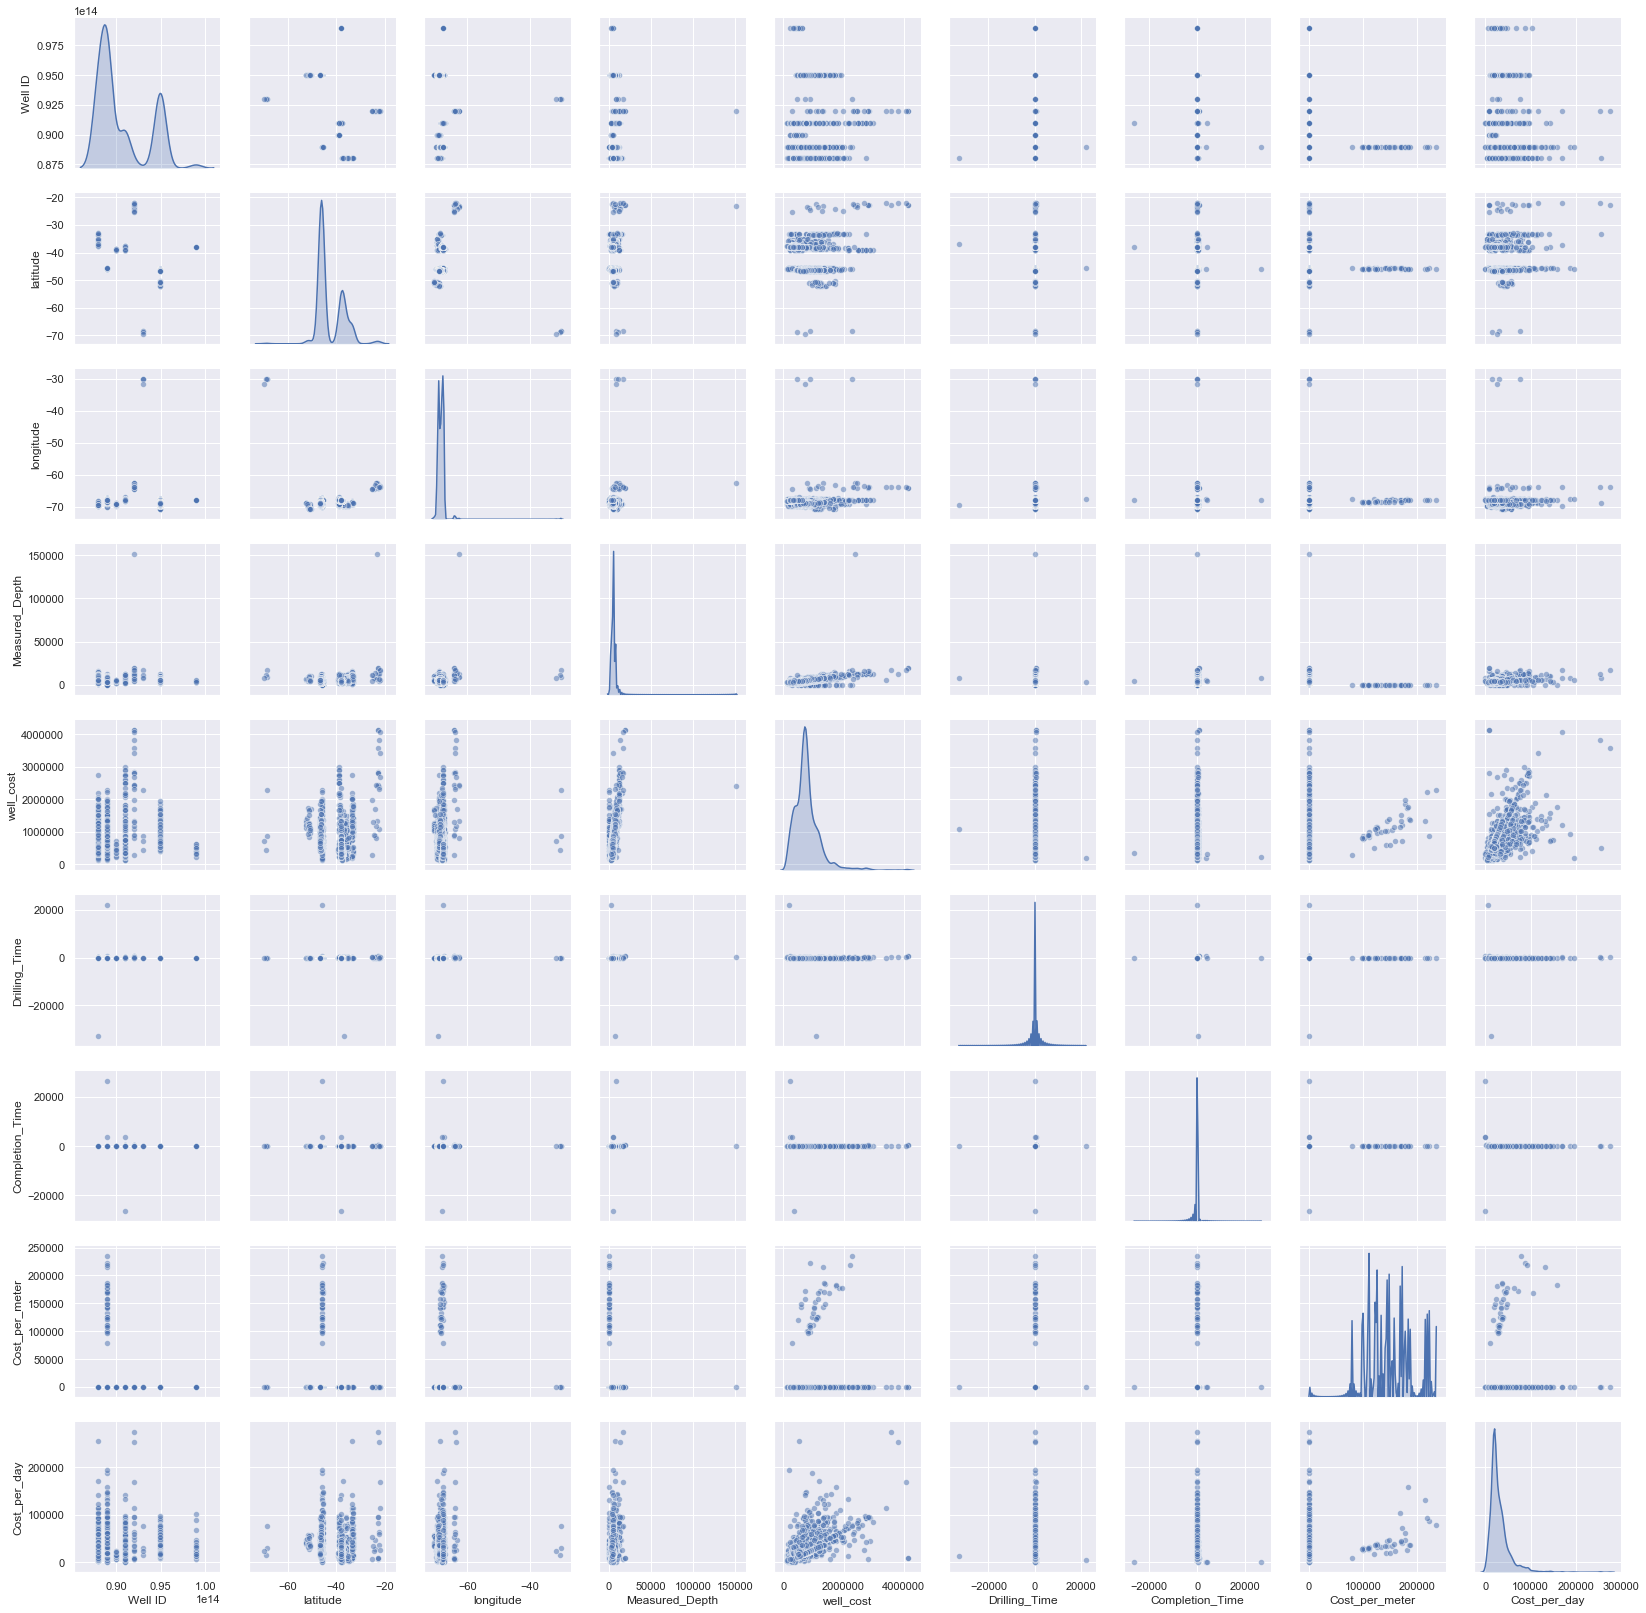

In [69]:
sns.pairplot(df, diag_kind = 'kde', plot_kws={'alpha': 0.5})

<Figure size 360x360 with 0 Axes>

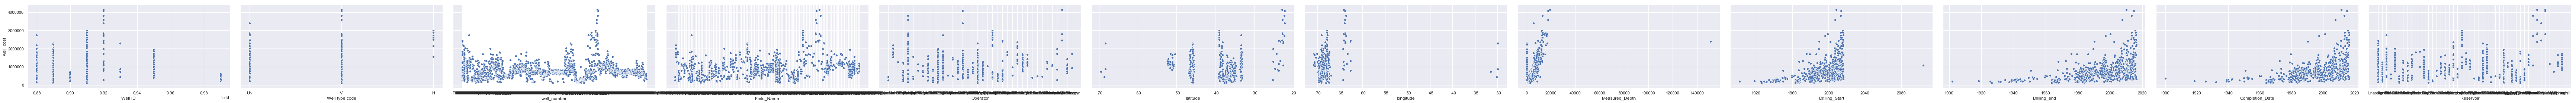

In [72]:
#creating scatter plots to see the correlations for well_cost versus all other features in the dataset
feat = data.columns[0:12]
plt.figure(figsize = (5,5))
p = sns.pairplot(data=data, x_vars=feat, y_vars=['well_cost'], height=4, aspect=2)
plt.show()

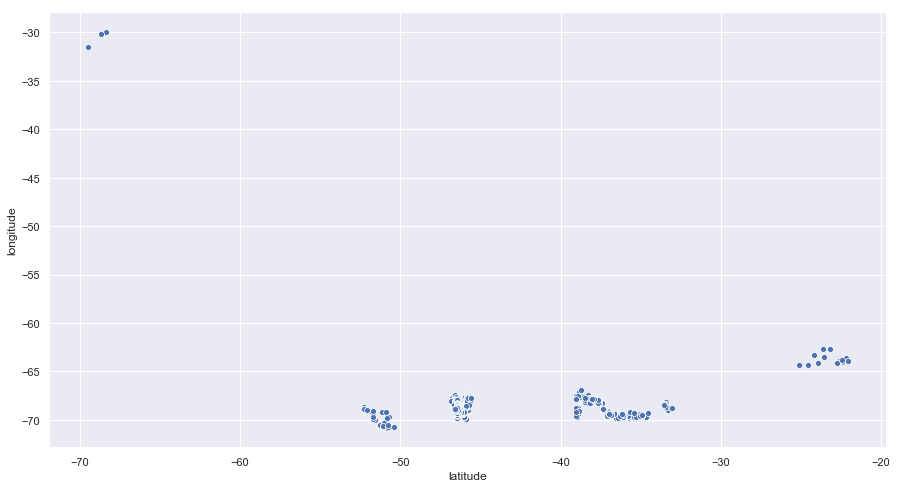

In [73]:
plt.figure(figsize = (15,8))
sns.scatterplot(data['latitude'], data['longitude'])

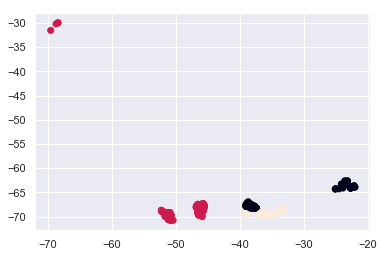

In [88]:
#K-means for geolocation clustering, as it uses Euclidean distance, and not Haversine formula as a distance function
coordinates = data[data.columns[5:7]]
x, y = kmeans2(whiten(coordinates), 3, iter = 20)  
plt.scatter(coordinates.iloc[:,0], coordinates.iloc[:,1], c=y);
plt.show()

In [83]:
#K-MEANS
#plot result
X = 
ptsymb = np.array(['b.','r.','m.','g.','c.','k.','b*','r*','m*','r^']);
plt.figure(figsize=(12,12))
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
for i in range(id_n):
    cluster=np.where(id_label==i)[0]
    plt.plot(X.latitude[cluster].values, X.longitude[cluster].values, ptsymb[i])
plt.show()

SyntaxError: invalid syntax (<ipython-input-83-39f6a09cb54f>, line 2)

In [ ]:
#Install Folium Library
#!pip install folium
#!conda install -c conda-forge folium

In [ ]:
#library helps you create several types of Leaflet maps.By default, Folium creates a map in a separate HTML file

In [86]:
import folium
#create the map.
map_pickup = folium.Map(location=[38.4161, 63.6167])
#adding the latitude and longitude points to the map.
data.apply(lambda row:folium.CircleMarker(location=[row['latitude'], row['longitude']], clustered_marker = True).add_to(map_pickup), axis=1)
#display the map: just ask for the object representation in jupyter notebook.
map_pickup
#optional: save the map.
map_pickup.save('map_pickup.html')

All the points on the map as circles
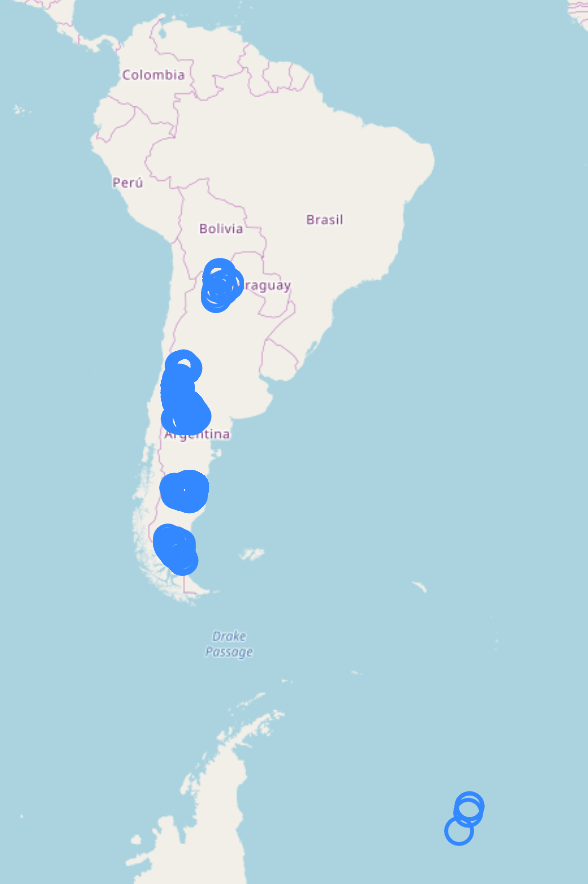

In [87]:
#df.to_excel('df.xlsx') save to play with it in Tableau